In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
import nltk
import random
from nltk.tokenize import word_tokenize,sent_tokenize
import pickle

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
docIdx = train_example_names.copy()

connection_tokens = {'s', 'of', 'and', 'in', 'on', 'for', 'from', 'the', 'act', 'coast', 'future', 'system', 'per'}

In [2]:
def text_cleaning(text):
    text = re.sub('[^A-Za-z]+', ' ', str(text)).strip() # remove unnecessary literals

    # remove extra spaces
    text = re.sub("\s+"," ", text)

    return text.lower().strip()

def is_name_ok(text):
    if len([c for c in text if c.isalnum()]) < 4:
        return False
    
    tokens = [t for t in text.split(' ') if len(t) > 3]
    tokens = [t for t in tokens if not t in connection_tokens]
    if len(tokens) < 3:
        return False

    return True
    
with open('data/all_preds_selected.txt', 'r') as f:
    selected_pred_labels = f.readlines()
    selected_pred_labels = [l.strip() for l in selected_pred_labels]

existing_labels = [text_cleaning(x) for x in metadata['dataset_label']] +\
                  [text_cleaning(x) for x in metadata['dataset_title']] +\
                  [text_cleaning(x) for x in metadata['cleaned_label']] +\
                  [text_cleaning(x) for x in selected_pred_labels]

to_remove = [
    'frequently asked questions', 'total maximum daily load tmd', 'health care facilities',
    'traumatic brain injury', 'north pacific high', 'droplet number concentration', 'great slave lake',
    'census block groups'
]

df = pd.read_csv(r'C:\projects\personal\kaggle\kaggle_coleridge_initiative\string_search\data\gov_data.csv')
print(len(df))


df['title'] = df.title.apply(text_cleaning)
titles = list(df.title.unique())
titles = [t for t in titles if not t in to_remove]
df = pd.DataFrame({'title': titles})
df = df.loc[df.title.apply(is_name_ok)]
df = pd.concat([df, pd.DataFrame({'title': existing_labels})], ignore_index= True).reset_index(drop = True)
titles = list(df.title.unique())
df = pd.DataFrame({'title': titles})
df['title'] = df.title.apply(text_cleaning)

# Sort labels by length in ascending order
existing_labels = sorted(list(df.title.values), key = len, reverse = True)
existing_labels = [l for l in existing_labels if len(l.split(' ')) < 10]
del df

print(len(existing_labels))

291984
59902


In [31]:
import pickle

with open(f'data/bert_ner_sentences/pos.pkl', 'rb') as f:
    pos_sentences_raw = pickle.load(f)

with open(f'data/bert_ner_sentences/neg.pkl', 'rb') as f:
    neg_sentences_raw = pickle.load(f)

pos_sentences = [text_cleaning(s) for s in pos_sentences_raw]
neg_sentences = [text_cleaning(s) for s in neg_sentences_raw]

print(f'pos size: {len(pos_sentences)}')
print(f'neg size: {len(neg_sentences)}')

pos size: 74846
neg size: 896822


## Remove labels from positive sentences to prevent overfitting

In [32]:
pos_sentences_with_label = pos_sentences
pos_sentences = []

for s in tqdm(pos_sentences_with_label):
    for l in existing_labels:
        if l in s:
            s = s.replace(l, '')

    pos_sentences.append(s)

pos_sentences = [re.sub("\s+"," ", s) for s in pos_sentences]

100%|██████████| 74846/74846 [14:02<00:00, 88.88it/s]


## Take first n tokens from each sentence

In [33]:
SENTENCE_TOKEN_SIZE = 20

def shorten_sentence(text):
    tokens = text.split(' ')
    return ' '.join(tokens[:SENTENCE_TOKEN_SIZE])

pos_sentences = [shorten_sentence(s) for s in pos_sentences]
neg_sentences = [shorten_sentence(s) for s in neg_sentences]

## Create Vectorizer

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

print('Creating TF-IDF vectorizer...')
all_sentences = pos_sentences + neg_sentences

vectorizer = TfidfVectorizer(
    max_features = 100000, ngram_range = (1, 2),
     use_idf = False, binary = True, min_df = 10,
     strip_accents = 'ascii').fit(all_sentences)

print('Creating data arrays...')
X = vectorizer.transform(all_sentences)
y = np.zeros(len(all_sentences))
y[:len(pos_sentences)] = 1

print('Saving vectorizer...')
with open(f'data/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

Creating TF-IDF vectorizer...
Creating data arrays...
Saving vectorizer...


## Split data

In [35]:
from sklearn.model_selection import train_test_split

print('Splitting data...')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

data = {
    'train_data': (X_train, y_train),
    'val_data': (X_val, y_val)
}

Splitting data...


## Fit model

In [36]:
"""from importlib import reload
reload(sklearn_model)"""

'from importlib import reload\nreload(sklearn_model)'

Minimize: False
Best hparameters:
{'alpha': 0.18875214286514458, 'model_class': <class 'sklearn.naive_bayes.MultinomialNB'>}
 93%|█████████▎| 14/15 [00:08<00:00,  1.81trial/s, best loss: -0.7830156912923429]

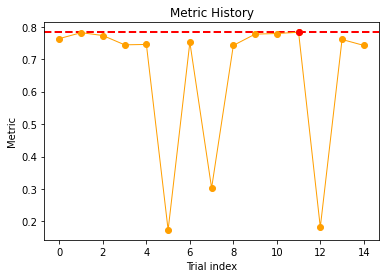

100%|██████████| 15/15 [00:08<00:00,  1.70trial/s, best loss: -0.7830156912923429]
HPARAMETER SEARCH FINISHED.
Fitting with best hparameters...
sklearn_model hparameters: {'alpha': 0.18875214286514458, 'model_class': <class 'sklearn.naive_bayes.MultinomialNB'>}
sklearn model threshold: 0.057887278827376654


In [37]:
def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

from mlmodels import sklearn_model
from mlmodels.search.hparameters import nb_params as hparams

delete_file('trials_sklearn')
model = sklearn_model.SklearnModel1(minimize_metric = False)

res = model.search(data, hparams.search_space, hparams.search_fixed, num_iter = 15)
best_hparams = res['best_params']
best_hparams.update(hparams.search_fixed)

print('Fitting with best hparameters...')
model = sklearn_model.SklearnModel1(**best_hparams)
model.fit(data)

model.save()

In [38]:
all_pred = model.predict([{'output': X}])[0]['output']
all_pred = all_pred[:, 1] > model.th * 0.75

In [39]:
from sklearn.metrics import recall_score

recall_score(y, all_pred, pos_label = 1)

0.8703604735055982

In [40]:
all_pred.mean()

0.3087515488829518

In [26]:
pos_pred_idx = np.argwhere(all_pred).squeeze()
neg_pred_idx = np.argwhere(np.logical_not(all_pred)).squeeze()

false_neg_idx = [i for i in neg_pred_idx if i < len(pos_sentences)]
print(len(false_neg_idx))

9835


In [27]:
i_ex = 1011

print(pos_sentences[false_neg_idx[i_ex]])
print(pos_sentences_raw[false_neg_idx[i_ex]])

however a quantitative suvr cutoff is more sensitive compared to
However, a quantitative SUVR cutoff is more sensitive compared to visual assessment to predict at-risk patients (Schreiber et al., 2015) , and we could easily obtain SUVR values from the ADNIMERGE dataset, which enables agreement with many other ADNI studies in terms of the study methods.


In [28]:
X_pos = vectorizer.transform(pos_sentences)
X_neg = vectorizer.transform(neg_sentences)

pos_pred = model.predict([{'output': X_pos}])[0]['output']
neg_pred = model.predict([{'output': X_neg}])[0]['output']
pos_pred = pos_pred[:, 1] > model.th * 0.75
neg_pred = neg_pred[:, 1] > model.th * 0.75

pred_sentences = []
pred_sentences += [pos_sentences_raw[i] for i in np.argwhere(pos_pred).squeeze()]
pred_sentences += [neg_sentences_raw[i] for i in np.argwhere(neg_pred).squeeze()]

In [29]:
len(pred_sentences)

348820

In [41]:
pred_sentences[0]

'International studies on student achievement, such as Trends in International Mathematics and Science Study (TIMMS) and the Programme for International Student Assessment (PISA) from past several years have documented a narrowing gap in gender differences in science and mathematics achievement (Else-Quest, Hyde, & Linn, 2010; Martin, Mullis, Foy, & Hooper, 2016; OECD, 2016) .'

In [42]:
import pickle

with open(f'data/bert_ner_data/pos_classified.pkl', 'wb') as f:
    pickle.dump(pred_sentences, f)

print(f'prediction size: {len(pred_sentences)}')

prediction size: 348820
